# [SITCOMTN-XXX] - M1M3 - analyze position and rotation stability throughout a tracking period

2023-12-14 Laura

This notebook evaluates displacements of M1M3 for X, Y, Z, RX, RY, and RZ during the period beteween slews while tracking (approximately 30 s) and check if they comply with the 2 micron and 2e-5 degree requirement.


In [62]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from astropy.time import Time, TimezoneInfo
from statsmodels.tsa.stattools import adfuller

from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient

from datetime import timedelta, datetime
import warnings
warnings.filterwarnings('ignore')

In [64]:
# create a client to retrieve datasets in the EFD database
client = makeEfdClient()

### Define relevant settings

#### Requirements

In [65]:
req_rms_position = 2e-3 ## mm, tolerance from repeatability requirement for IMS positional
req_rms_rotation = 2e-5 ## degrees, tolerance from repeatability requirement for IMS rotational

### Define functions

In [66]:
def computeStability(
    df_ims,  # input data frame
    referenceTime = "2023-06-01T06:00:0Z",  # time for slew stop (T0)
    imsColumn="xPosition",  # IMS column
    rmsReq=2e-3,  # requirement in appropriate units
    chi2prob=0.999,  # confidence level for IMS variable wrt to long term value and variance to agree   
):
    if "Position" in imsColumn:
        units = "mm"
        ylimMax = rmsReq #+ 0.005
    elif "Rotation" in imsColumn:
        units = "deg"
        ylimMax = rmsReq #+ 0.0001
    else:
        print("Unidentified column")
        return -1
    

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def computeSettleTimeBetweenSlew(
    df_ims,  # input data frame
    referenceTime="2023-06-01T06:00:0Z",  # time for slew stop (T0)
    lo_delta_t=5,  # in seconds   ****CAMBIAR ESTOS VALORES***
    hi_delta_t=30,  # in seconds
    imsColumn="xPosition",  # IMS column
    rmsReq=2e-3,  # requirement in appropriate units
    #req_delta_t=3,  # time for settling, in seconds
    chi2prob=0.999,  # confidence level for IMS variable wrt to long term value and variance to agree
):
    if "Position" in imsColumn:
        units = "mm"
        ylimMax = rmsReq + 0.005
    elif "Rotation" in imsColumn:
        units = "deg"
        ylimMax = rmsReq + 0.0001
    else:
        print("Unidentified column")
        return -1
  
    for i in range(slews_count - 1):
        slew_start = slews.index[i]
        slew_end = slews.index[i + 1]

    # Ajusta los tiempos T0 y T1 para analizar el seguimiento entre los SLEW
    T0 = slew_end  # T0 es el final de un SLEW
    T1 = slew_start  # T1 es el inicio del siguiente SLEW
    
    delta_window = [
        pd.Timedelta(lo_delta_t, "seconds"),
        pd.Timedelta(hi_delta_t, "seconds"),
    ]
    # zoom around the T0 of interest
    TZoom = [T0 - delta_window[0], T0 + delta_window[1]]
    
    # targetVariablePlot takes the data frame for the complete plot range
    targetVariablePlot = df_ims[imsColumn][TZoom[0] : TZoom[1]]
    # targetVariableCheck takes the data from the slew stop, until the end of the plot
    targetVariableCheck = df_ims[imsColumn][T0 : TZoom[1]]
    # targetVariableWindow takes the data from the slew stop, until the end of requirement window
    targetVariableWindow = df_ims[imsColumn][T0:T1]
    idxT0 = df_ims.index[  # index in dataframe closest in time to slew stop
        df_ims.index.get_indexer([pd.to_datetime(T0)], method="nearest")
    ]
    idxT1 = (
        df_ims.index[  # index in dataframe closest in time to end of requirement window
            df_ims.index.get_indexer([pd.to_datetime(T1)], method="nearest")
        ]
    )
    idxTend = df_ims.index[  # index in dataframe closest in time to end of plot
        df_ims.index.get_indexer(
            [pd.to_datetime(T0 + delta_window[1])], method="nearest"
        )
    ]
    targetVariableReference = [
        float(df_ims[imsColumn][idxT0]),
        float(df_ims[imsColumn][idxTend]),
    ]
    if len(targetVariablePlot.index) == 0:
        print("Data frame is empty")
        return -1

    # it is important that the end of the plot (targetVariableReference[1])
    # does not hit another slew or movement, nor at any point in the middle of the window

    # correct IMS variable wrt end of plot
    correctedVariablePlot = targetVariablePlot - targetVariableReference[1]
    correctedVariableCheck = targetVariableCheck - targetVariableReference[1]
    correctedVariableCheck2 = np.square(correctedVariableCheck)

    # number of values where the chi2 will be computed
    rolling = 10  # 50 is approx. 1 s
    # chi2 right tail probability for N=rolling dof at chi2prob CL
    crit = stats.chi2.ppf(chi2prob, rolling)

    rms = correctedVariableCheck.rolling(rolling).std()
    var = correctedVariableCheck.rolling(rolling).var()
    mean = abs(correctedVariableCheck.rolling(rolling).mean())

    # compute the chi2 against the null hypothesis
    # the x_i are the measurements in a window (wrt to reference at end of plot)
    # the variance is for the same values
    # so chi2 = sum_N[(x_i - 0)**2/variance] where N = rolling
    sum2 = correctedVariableCheck2.rolling(rolling).sum()
    chi2 = sum2 / var
    # check the chi2 at each step using rollingCheck as the number of consecutive instances in which
    # chi2 has to be under the critical value
    # or rms and bias be both already 10% of requirement
    PFCheck = (chi2 < crit) | ((rms < 0.1 * rmsReq) & (mean < 0.1 * rmsReq))
    # PFCheck = (rms < 0.2 * rmsReq) & (mean < 0.5 * rmsReq)
    rollingCheck = 10
    stabilityCheck = (
        PFCheck.rolling(rollingCheck).apply(lambda s: s.all()) > 0
    )  # true if rollingCheck consecutive true values of PFcheck
    if len(stabilityCheck[stabilityCheck == True]) < rollingCheck:  ## == 0:
        # print(f"Not settled within {postPadding} s window")
        settleTime = False
    elif rms[stabilityCheck[stabilityCheck == True].index[0]] <= rmsReq:
        settleTime = stabilityCheck[stabilityCheck == True].index[rollingCheck]
    else:
        n = 1
        while (
            rms[stabilityCheck[stabilityCheck == True].index[n + rollingCheck]] > rmsReq
        ):
            settleTime = stabilityCheck[stabilityCheck == True].index[n + rollingCheck]
            n = n + 1
        # if settleTime < referenceTime:
        #    settleTime = referenceTime
    settleInterval = -1
    if settleTime:
        settleInterval = settleTime - referenceTime
        if settleInterval.total_seconds() < 0:
            print(f"Already settled at slew stop")
            settleInterval = 0
        else:
            settleInterval = settleInterval.total_seconds()

    title = imsColumn
    fig = plt.figure()
    label = "Corrected " + imsColumn + "(" + units + ") difference wrt end of plot"
    plt.plot(
        correctedVariablePlot,
        color="red",
        ls="dashed",
        lw="0.5",
        label=label,
    )
    plt.plot(rms, label=f"RMS of corrected value, using {rolling} rolling values")
    plt.plot(
        mean,
        ls="dashed",
        label=f"Bias of corrected value, using {rolling} rolling values",
    )
    if settleTime:
        plt.arrow(
            settleTime,
            1.1 * rmsReq,
            0.0,
            -0.5 * rmsReq,
            width=2e-6,
            head_length=0.5 * rmsReq,
        )
        plt.text(
            0.5,
            0.92,
            "Settle time =" + " {:.2f} ".format(settleInterval) + " s",
            transform=fig.transFigure,
        )
    plt.axvline(T0, lw="1.25", c="k", ls="dashed", label="Slew stop")
    plt.axhline(-rmsReq, lw="0.75", c="k", ls="dashed", label="IMS repeatability req.")
    plt.axhline(rmsReq, lw="0.75", c="k", ls="dashed")
    plt.xlabel("Time [UTC]")
    plt.ylabel(f"{imsColumn} {units}")
    plt.ylim(-ylimMax, ylimMax)
    fig.autofmt_xdate()
    plt.legend(loc="upper right", fontsize="8")
    fig.tight_layout()

    if not settleTime:
        return -1

    return settleInterval


In [187]:
def compareIMSMount(
    df_ims,
    df_mtmount_ele,
    df_mtmount_azi,
    referenceTime="2023-06-01 06:53:37.326",
    end_t="2023-06-01 06:53:37.326",
    delta_t=5
):
    fig, axs = plt.subplots(5, 1, dpi=125, figsize=(6, 8))
    t_start_plot = pd.to_datetime(referenceTime) - pd.to_timedelta(delta_t, unit="s")
    t_end_plot = pd.to_datetime(end_t) + pd.to_timedelta(delta_t, unit="s")

    ax = axs[0]
    actpos_ele = df_mtmount_ele["actualPosition"][t_start_plot:t_end_plot]
    ax.plot(actpos_ele, color="red", lw=0.5)  
    ax.axvline(pd.to_datetime(referenceTime), lw=1, c="k", ls="--") 
    ax.axvline(pd.to_datetime(end_t), lw=1, c="k", ls="--")  
    ax.set_ylabel("Elevation\nPosition\n[deg]")
    ax.text(
        pd.to_datetime(referenceTime)+ pd.to_timedelta((t_start_plot - referenceTime) / 2),
        max(actpos_ele) + 0.01* max(actpos_ele),
        "Slew",
        horizontalalignment="center",
        fontsize=8,
    )
    ax.text(
        pd.to_datetime(end_t) - pd.to_timedelta((end_t - t_end_plot) / 2),
        max(actpos_ele) + 0.01* max(actpos_ele),
        "Slew",
        horizontalalignment="center",
        fontsize=8,
    )
    ax.text(
        pd.to_datetime(referenceTime) + pd.to_timedelta((end_t - referenceTime) / 2),
        max(actpos_ele) + 0.01* max(actpos_ele),
        "Tracking",
        horizontalalignment="center",
        fontsize=8,
    )
      
    ax = axs[1]
    actpos_azi = df_mtmount_azi["actualPosition"][t_start_plot:t_end_plot]
    ax.plot(actpos_azi, color="red", lw=0.5)
    ax.axvline(pd.to_datetime(referenceTime), lw=1, c="k", ls="--", label="Starts Tracking") 
    ax.axvline(pd.to_datetime(end_t), lw=1, c="k", ls="--", label="End Tracking")
    ax.set_ylabel("Azimuth\nPosition\n[deg]")

    plotstring = ["xPosition", "yPosition", "zPosition"]
    plotrange = np.arange(len(plotstring))
    for i in plotrange:
        ax = axs[i + 2]
        pos = df_ims[plotstring[i]][t_start_plot:t_end_plot]
        ax.plot(pos, color="red", lw="0.5")
        ax.axvline(pd.to_datetime(referenceTime), lw=1, c="k", ls="--")
        ax.axvline(pd.to_datetime(end_t), lw=1, c="k", ls="--")
        ax.set_ylabel(plotstring[i] + " \n[mm]")
    ax.set_xlabel("UTC")
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=1)
    fig.suptitle(referenceTime)
    fig.legend()
    fig.tight_layout()

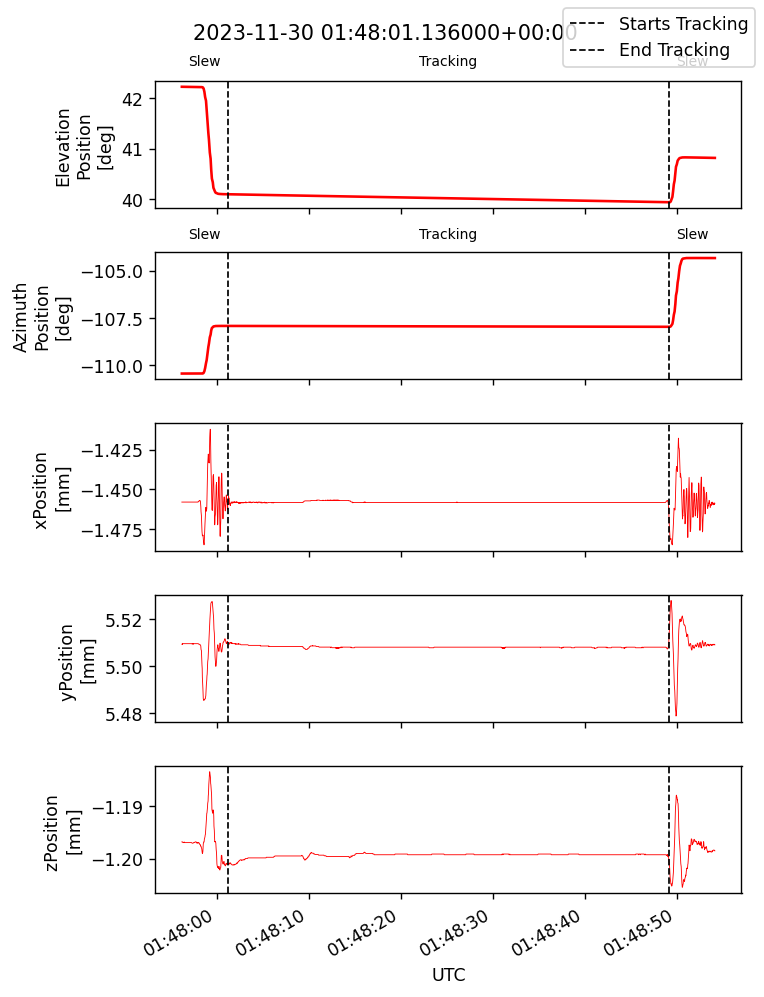

In [186]:
%matplotlib inline
compareIMSMount(
    df_ims,
    df_mtmount_ele,
    df_mtmount_azi,
    t0,
    t1,
    delta_t
)

### Definition of case

#### Observation day

In [69]:
dayObs = 20231129  #20231128 

In [70]:
## Define column names
all_columns = [
    "xPosition",
    "yPosition",
    "zPosition",
    "xRotation",
    "yRotation",
    "zRotation",
]
pos_columns = [c for c in all_columns if "Position" in c]
rot_columns = [c for c in all_columns if "Rotation" in c]

In [114]:
delta_t = 5

#### Get slew stops

In [71]:
# Select data from a given date
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(dayObs)

# Get lists of slew and track events
slews = [e for e in events if e.type==TMAState.SLEWING]
tracks = [e for e in events if e.type==TMAState.TRACKING]
print(f'Found {len(slews)} slews and {len(tracks)} tracks')

Found 492 slews and 378 tracks


In [72]:
# Get events related to soak tests (block 137 currently)
block137Events = []
for event in events:
    blockInfos = event.blockInfos
    if blockInfos is None:
        continue  # no block info attached to event at all

    # check if any of the attached blockInfos are for block 137
    blockNums = {b.blockNumber for b in blockInfos}
    if 137 in blockNums:
        block137Events.append(event)

print(f"Of the {len(events)} events, {len(block137Events)} relate to block 137.")

Of the 870 events, 750 relate to block 137.


In [39]:
# Print out sequential number of events that have certain characteristics
t = 0
for i in range(len(block137Events)):
    if (
        block137Events[i].endReason == TMAState.SLEWING
        and block137Events[i].type == TMAState.TRACKING
    ):
        t = t + 1
        print(block137Events[i].seqNum, end=", ")

12, 14, 16, 18, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 119, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 195, 197, 199, 201, 203, 205, 207, 209, 211, 213, 215, 217, 219, 221, 223, 225, 227, 229, 231, 233, 235, 237, 239, 241, 243, 245, 247, 249, 251, 253, 255, 257, 259, 261, 263, 265, 267, 269, 271, 273, 275, 277, 279, 281, 283, 285, 287, 289, 291, 293, 295, 297, 299, 301, 309, 311, 313, 315, 317, 319, 321, 323, 325, 327, 329, 331, 333, 335, 337, 339, 341, 343, 345, 347, 349, 351, 353, 355, 357, 364, 371, 373, 375, 378, 386, 396, 398, 400, 402, 404, 406, 408, 410, 412, 414, 416, 418, 420, 422, 424, 426, 428, 430, 432, 434, 436, 438, 440, 442, 444, 447, 449, 451, 453, 455, 457, 459, 461, 463, 465, 467, 469, 471, 473, 475, 477, 479, 481, 483, 485, 487, 489, 491, 493, 495, 497, 499, 501, 503, 505, 507, 509, 511, 513, 515, 517, 519, 521, 523, 52

In [73]:
# Number of TRACKING in block 137
print(f"Of the {len(block137Events)} events of block 137, {t} are trackings.")

Of the 750 events of block 137, 64 are trackings.


In [74]:
# Select a event of trancking in block 137
targetSeqNum = 209

In [75]:
# find the appropriate tracking index that has the sequential number selected above
for t, tl in enumerate(tracks):
    if tl.seqNum == targetSeqNum:
        i_track = t
        break
print(f"Event with seqNum {targetSeqNum} corresponds to track number {i_track}")

Event with seqNum 209 corresponds to track number 64


In [76]:
tracks[i_track]

dayObs: 20231129
seqNum: 209
type: TRACKING
endReason: SLEWING
duration: 47.95356202125549
begin: <Time object: scale='utc' format='unix' value=1701308881.1355748>
end: <Time object: scale='utc' format='unix' value=1701308929.0891368>
blockInfos: 
    dayObs: 20231129
    seqNum: 61
    blockNumber: 137
    blockId: BL137_O_20231129_000061
    begin: 2023-11-30T01:47:57.231
    end: 2023-11-30T01:48:46.170
    salIndices: [102653]
    tickets: ['SITCOM-885']
    states: 
       RUNNING @ 2023-11-30T01:47:57.231  
       RUNNING @ 2023-11-30T01:48:46.167  
        ENDING @ 2023-11-30T01:48:46.169  
          DONE @ 2023-11-30T01:48:46.170
    dayObs: 20231129
    seqNum: 62
    blockNumber: 137
    blockId: BL137_O_20231129_000062
    begin: 2023-11-30T01:48:48.095
    end: 2023-11-30T01:49:36.961
    salIndices: [102654]
    tickets: ['SITCOM-885']
    states: 
       RUNNING @ 2023-11-30T01:48:48.095  
       RUNNING @ 2023-11-30T01:49:36.958  
        ENDING @ 2023-11-30T01:49:36.959

In [115]:
# Select the information during the tracking
t0 = Time(tracks[i_track].begin, format="isot", scale="utc")
t0 = pd.to_datetime(t0.value, utc=True)  # astropy Time to Timestamp conversion
t1 = Time(tracks[i_track].end, format="isot", scale="utc")
t1 = pd.to_datetime(t1.value, utc=True)  # astropy Time to Timestamp conversion
print("Tracking stop at:", t1)

# Get IMS data
df_ims = getEfdData(
    client, "lsst.sal.MTM1M3.imsData", event=tracks[i_track], postPadding=delta_t, prePadding=delta_t)
df_ims = df_ims[all_columns]
# Convert meter to milimeter
df_ims[pos_columns] = df_ims[pos_columns] * 1e3

Tracking stop at: 2023-11-30 01:48:49.089000+00:00


In [116]:
df_mtmount_ele = getEfdData(
    client, "lsst.sal.MTMount.elevation", event=tracks[i_track], postPadding=delta_t, prePadding=delta_t)

df_mtmount_azi = getEfdData(
    client, "lsst.sal.MTMount.azimuth", event=tracks[i_track], postPadding=delta_t, prePadding=delta_t)

### Look at data

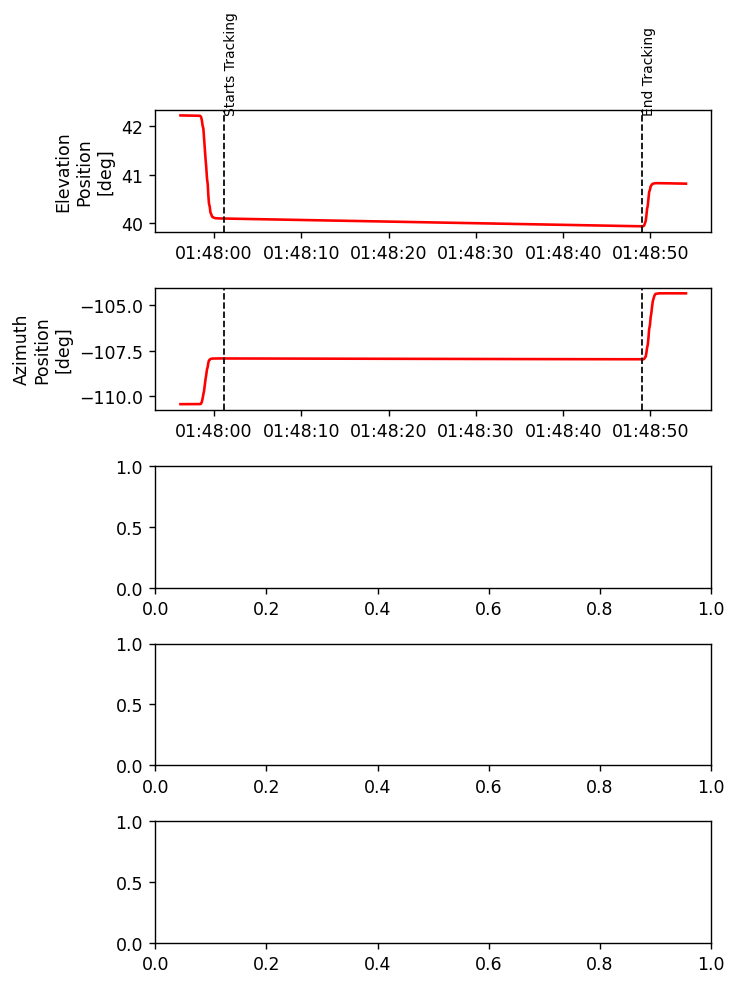

In [143]:
%matplotlib inline
compareIMSMount(
    df_ims,
    df_mtmount_ele,
    df_mtmount_azi,
    t0,
    t1,
    delta_t
)